In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from typing import Tuple
from sklearn import preprocessing

In [43]:
def load_data() -> Tuple[np.ndarray, np.ndarray]:
    data = pd.read_csv("./data/data.csv").drop(["Unnamed: 0"], axis=1)
    labels = pd.read_csv("./data/labels.csv")["Class"]
        
    # Encodes string labels as ints
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(labels)
    
    return data.to_numpy(), y
X, y = load_data()

# First feature reduction to reduce run time

In [81]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

# Dropping the constant features
X_nonconst = VarianceThreshold().fit_transform(X)

# Doing feature selection by choosing the k features with the largest F-statistic
k = 200
X_fstat = SelectKBest(score_func=f_classif, k=k).fit_transform(X_nonconst, y)

# Feature selection using multi-class logistic regression

In [399]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score as bacc

def cross_validate(n_folds, C_list, X, y):
    """
    Cross-validates the parameter values in C_list and
    returns a numpy.ndarray where the first index corresponds to the
    different values in C_list and the columns correspond
    to the different folds. Each of the elements has the balanced
    accuracy score for a given parameter value adn fold.
    """
    score_matrix = np.zeros((len(C_list), n_folds))
    skf = StratifiedKFold(n_splits=n_folds)
    ix = 0
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        jx = 0
        for val in C_list:
            mdl = LogisticRegression(C=val,
                                    multi_class='ovr', 
                                    solver='liblinear',
                                    intercept_scaling=10000).fit(X_train, y_train)
            y_pred = mdl.predict(X_test)
            score_matrix[jx, ix] = bacc(y_test, y_pred)
            
            jx += 1
        ix += 1
        
    return score_matrix

In [400]:
n_folds = 10
c_list = np.logspace(-4, 0, 100)

score_matrix = cross_validate(n_folds, c_list, X_fstat, y)
cv_mean = np.mean(score_matrix, axis=1)
cv_std = np.std(score_matrix, axis=1)
idx_max_mean = np.argmax( cv_mean )
c_max = c_list[idx_max_mean]
idx_c_1se = np.where(
    (cv_mean >= cv_mean[idx_max_mean] - cv_std[idx_max_mean] / np.sqrt(n_folds)) &
    (cv_mean <= cv_mean[idx_max_mean])
)[0][0]
c_1se = c_list[idx_c_1se]

In [426]:
c_max

0.009545484566618348

# Gaining confidence in feature selection thorugh bootstrap

array([360., 382., 387., 390., 374., 393., 386., 372., 369., 387., 373.,
       368., 368., 367., 377., 369., 374., 369., 376., 357., 365., 390.,
       394., 376., 382., 374., 374., 361., 333., 364., 362., 384., 372.,
       385., 377., 370., 381., 380., 365., 370., 382., 365., 353., 375.,
       373., 375., 374., 365., 389., 373., 370., 365., 374., 364., 389.,
       374., 372., 375., 361., 361., 374., 256., 329., 384., 390., 374.,
       370., 368., 384., 366., 380., 381., 377., 385., 356., 377., 355.,
       380., 368., 379., 369., 390., 384., 380., 372., 384., 372., 358.,
       396., 369., 361., 360., 361., 399., 379., 373., 362., 381., 374.,
       371., 375., 389., 378., 382., 374., 378., 379., 371., 366., 368.,
       377., 369., 388., 377., 364., 384., 373., 395., 357., 363., 357.,
       385., 384., 371., 374., 374., 385., 374., 370., 369., 373., 386.,
       398., 390., 375., 391., 364., 370., 374., 385., 367., 381., 375.,
       368., 387., 377., 368., 365., 377., 374., 36

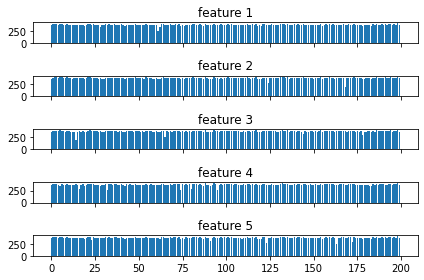

In [408]:
from sklearn.linear_model import LogisticRegression

n_bootstrap_samples = 500
sample_size = 150
zero_tol = 0.0001

# Creating bootstrap sample and records how often a given feature is 
# selected in the LogisticRegression for c_max.
selected_feature_counters = { 
    0: np.zeros(k),
    1: np.zeros(k),
    2: np.zeros(k),
    3: np.zeros(k),
    4: np.zeros(k),
}
for ix in range(n_bootstrap_samples):
    idx_list = np.random.choice(X_fstat.shape[1], sample_size, replace=False)
    X_bootstrap = X_fstat[:,idx_list]Filter
    beta = LogisticRegression(C=c_max*0.01,
                             multi_class='ovr', 
                             solver='liblinear',
                             intercept_scaling=10000).fit(X_bootstrap, y).coef_
    
    # Assumes that the beta arrays for the differen
    # classes comes in the same order, and calculates
    # the frequency with which every frequency is present
    jx = 0
    for class_beta in beta:
        non_zero_idx = np.where( abs(class_beta) > zero_tol )
        non_zero_feature_idx = idx_list[non_zero_idx]
        for idx in non_zero_feature_idx:
            selected_feature_counters[jx][idx] += 1
        jx += 1
        
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
ax1.bar(range(200), selected_feature_counters[0])
ax1.set_title("feature 1")

ax2.bar(range(200), selected_feature_counters[1])
ax2.set_title("feature 2")

ax3.bar(range(200), selected_feature_counters[2])
ax3.set_title("feature 3")

ax4.bar(range(200), selected_feature_counters[3])
ax4.set_title("feature 4")

ax5.bar(range(200), selected_feature_counters[4])    
ax5.set_title("feature 5")

fig.tight_layout()
selected_feature_counters[0]

## Selection stability trhough selection frequency relative to bootstrap samples

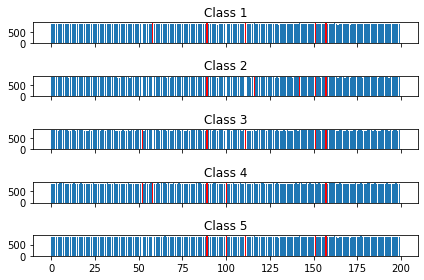

In [424]:
from sklearn.linear_model import LogisticRegression

n_bootstrap_samples = 1000
sample_size = 170
zero_tol = 0

# Creating bootstrap sample and records how often a given feature is 
# selected in the LogisticRegression for c_max.
selected_feature_counters = [ 
    np.zeros(k),
    np.zeros(k),
    np.zeros(k),
    np.zeros(k),
    np.zeros(k),
]
avrg_abs_coefs = [ 
    np.zeros(k),
    np.zeros(k),
    np.zeros(k),
    np.zeros(k),
    np.zeros(k),
]
for ix in range(n_bootstrap_samples):
    idx_list = np.random.choice(X_fstat.shape[1], sample_size, replace=False)
    X_bootstrap = X_fstat[:,idx_list]
    beta = LogisticRegression(C=c_max,
                             multi_class='ovr', 
                             solver='liblinear',
                             intercept_scaling=10000).fit(X_bootstrap, y).coef_
    
    # Assumes that the beta arrays for the differen
    # classes comes in the same order, and calculates
    # the frequency with which every feature is present
    # as well as each coefficients avrage absolute value
    # over every bootstrap sample
    jx = 0
    for class_beta in beta:
        non_zero_idx = np.where( abs(class_beta) > zero_tol )
        non_zero_feature_idx = idx_list[non_zero_idx]
        for (feature_idx, coef_idx) in zip(non_zero_feature_idx, non_zero_idx[0]):
            selected_feature_counters[jx][feature_idx] += 1
            avrg_abs_coefs[jx][feature_idx] += abs(class_beta[coef_idx])/n_bootstrap_samples
        jx += 1
        
# Selecting the 5 features that have the highest selection stability.
# If multiple features are equally stable we chose the features with the larges
# absolute value
top5_stable_features = [ 
    np.zeros((5,2)),
    np.zeros((5,2)),
    np.zeros((5,2)),
    np.zeros((5,2)),
    np.zeros((5,2)),
]
ix = 0
for ix in range(len(selected_feature_counters)):
    # List containing tuples of (index, value)
    idx_value_max_list = []  
    
    # Appends the largest value's index
    # and sets the value to zero.
    idx_max = np.argmax(selected_feature_counters[ix])
    val_max = selected_feature_counters[ix][idx_max]
    idx_value_max_list.append( (idx_max, val_max) )
    selected_feature_counters[ix][idx_max] = 0
    
    # repats above until the five largest frequency features
    # are saved. If two features have the same frequency we pick
    # the one wih the largest avrage absolute value
    while len(idx_value_max_list) < 5:
        last_item = idx_value_max_list[len(idx_value_max_list)-1]
        idx_max = np.argmax(selected_feature_counters[ix])
        val_max = selected_feature_counters[ix][idx_max]
        if last_item[1] == val_max and avrg_abs_coefs[ix][last_item[0]] > avrg_abs_coefs[ix][idx_max]:
            # If frequeny is equal and current entry has larger avrage
            # absolute value coefficient we append it set that frequency 
            # to zero in selected_feature_counters
            idx_value_max_list.append( (idx_max, val_max) )
            selected_feature_counters[ix][idx_max] = 0            
        elif last_item[1] == val_max and avrg_abs_coefs[ix][last_item[0]] < avrg_abs_coefs[ix][idx_max]:
            # If frequeny is equal and current entry has smaller avrage
            # absolute value coefficient we replace it by the new element
            # and set that frequency to zero in selected_feature_counters
            idx_value_max_list[len(idx_value_max_list)-1] = (idx_max, val_max)
            selected_feature_counters[ix][idx_max] = 0
        else:
            idx_value_max_list.append( (idx_max, val_max) )
            selected_feature_counters[ix][idx_max] = 0      
    top5_stable_features[ix] = idx_value_max_list
    ix += 1 

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
ax1.set_title("Class 1")
ax1.bar(range(200), selected_feature_counters[0])
for elem in top5_stable_features[0]:
    ax1.bar(elem[0], elem[1], color="red")

ax2.set_title("Class 2")
ax2.bar(range(200), selected_feature_counters[1])
for elem in top5_stable_features[1]:
    ax2.bar(elem[0], elem[1], color="red")

ax3.set_title("Class 3")
ax3.bar(range(200), selected_feature_counters[2])
for elem in top5_stable_features[2]:
    ax3.bar(elem[0], elem[1], color="red")

ax4.set_title("Class 4")
ax4.bar(range(200), selected_feature_counters[3])
for elem in top5_stable_features[3]:
    ax4.bar(elem[0], elem[1], color="red")

ax5.set_title("Class 5")
ax5.bar(range(200), selected_feature_counters[4])
for elem in top5_stable_features[4]:
    ax5.bar(elem[0], elem[1], color="red")

fig.tight_layout()
fig.savefig("feature_selection_histogram.png")

In [425]:
top5_stable_features

[[(58, 875.0), (89, 875.0), (157, 873.0), (151, 872.0), (111, 871.0)],
 [(89, 875.0), (157, 873.0), (151, 872.0), (116, 871.0), (142, 870.0)],
 [(89, 875.0), (157, 873.0), (52, 872.0), (151, 872.0), (111, 871.0)],
 [(58, 875.0), (89, 875.0), (100, 873.0), (157, 873.0), (52, 872.0)],
 [(89, 875.0), (100, 873.0), (157, 873.0), (151, 872.0), (111, 871.0)]]

Above we can see the top 5 most stable features, which they self are very unstable. When looking at the top counts for how many times a given feature is selected it varies quite a bit, which probably is the driving factor for the results we are seeing.